In [12]:
# Tensorflow 2 version

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
from sklearn.metrics import confusion_matrix

from tensorflow.keras import __version__
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense, Dropout,
                                     Flatten, Input, MaxPooling2D, Conv2D)
from tensorflow.keras.models import Model

import utils.CNN_utils as cu

%matplotlib inline

In [13]:
def crop_center(im, new_w, new_h):
    width, height = im.size   # Get dimensions

    left = (width - new_w)/2
    top = (height - new_h)/2
    right = (width + new_w)/2
    bottom = (height + new_h)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    
    return im

In [14]:
image_path = "/data/pg-ds_cit/Projects/Astronomy/AstronomyProject/Images"

In [15]:
#positive class - asteroids
filenames_train = [os.path.join(f"{image_path}/train/asteroids", file) for file in  os.listdir(f"{image_path}/train/asteroids")]
filenames_train.extend([os.path.join(f"{image_path}/valid/asteroids", file) for file in  os.listdir(f"{image_path}/valid/asteroids")])
filenames_test = [os.path.join(f"{image_path}/test/asteroids", file) for file in  os.listdir(f"{image_path}/test/asteroids")]

crop_w = 20
crop_h = 20

mode = "Original"

#get train data set from asteroid images in train and valid dirs
trainSetX = []
for i, file in enumerate(filenames_train):
    im = Image.open(file)
    if mode == "Crop":
        im = crop_center(im, crop_w, crop_h)
    elif mode == "Resize":
        im = im.resize((crop_w, crop_h))
    else:
        pass
    im = np.asarray(im)
    trainSetX.append(im)
#create labels
trainSetY = np.ones((len(filenames_train)), dtype=float)

#get test data set from asteroid images in test dirs
testSetX = []
for i, file in enumerate(filenames_test):
    im = Image.open(file)
    if mode == "Crop":
        im = crop_center(im, crop_w, crop_h)
    elif mode == "Resize":
        im = im.resize((crop_w, crop_h))
    else:
        pass
    im = np.asarray(im)
    testSetX.append(im)
#create labels
testSetY = np.ones((len(filenames_test)), dtype=float)

In [16]:
np.shape(trainSetX[0])

(101, 101)

In [5]:
#negative class - other
filenames_train = [os.path.join(f"{image_path}/train/other", file) for file in  os.listdir(f"{image_path}/train/other")]
filenames_train.extend([os.path.join(f"{image_path}/valid/other", file) for file in  os.listdir(f"{image_path}/valid/other")])
filenames_test = [os.path.join(f"{image_path}/test/other", file) for file in  os.listdir(f"{image_path}/test/other")]

#get train data set from other category in train and valid dirs
for i, file in enumerate(filenames_train):
    im = Image.open(file)
    if mode == "Crop":
        im = crop_center(im, crop_w, crop_h)
    elif mode == "Resize":
        im = im.resize((crop_w, crop_h))
    else:
        pass
    im = np.asarray(im)
    trainSetX = np.append(trainSetX, im[None,...], 0)
#add negative labels
trainSetY = np.append(trainSetY, np.zeros((len(filenames_train)), dtype=float), 0)

#get test data set from other category in test dirs
for i, file in enumerate(filenames_test):
    im = Image.open(file)
    if mode == "Crop":
        im = crop_center(im, crop_w, crop_h)
    elif mode == "Resize":
        im = im.resize((crop_w, crop_h))
    else:
        pass
    im = np.asarray(im)
    testSetX = np.append(testSetX, im[None,...], 0)
#add negative labels
testSetY = np.append(testSetY, np.zeros((len(filenames_test)), dtype=float), 0)

In [6]:
print('Using Keras version:', __version__, 'with backend:', K.backend(), tf.__version__)

# Choose size of validation set
validationSetPortion = 0.1

# Uses training data only between a given range
magRange = [20, 26]

# Training hyperparameters
subtract_pixel_mean = False
epochs = 500
early_stop_patience = 20
learning_rate = 0.001
batch_size = 256
# dr = 5 / epochs  # Parameter for Learning rate decay

# Make sure data is float32 to have enough decimals after normalization
X_train = trainSetX.astype('float32')
X_test = testSetX.astype('float32')

# Normalize pixel values between 0 and 1
X_train /= 2**8
X_test /= 2**8

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean

Y_train = trainSetY
Y_test = testSetY

# input image dimensions
img_rows, img_cols = X_train.shape[1:3]

# Convert to correct Keras format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

#Shuffle data sets
np.random.seed(123)
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices]
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]

Using Keras version: 2.4.0 with backend: tensorflow 2.3.1


In [7]:
print()
print('Data loaded: train:', len(X_train), 'test:', len(X_test))
print('trainSetX:', trainSetX.shape)
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

dropoutProb = 0.25

input = Input(shape=input_shape)
x = BatchNormalization()(input)
x = Conv2D(nb_filters, kernel_size,
           padding='same',
           input_shape=input_shape,
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()
x = Activation("relu")(x)

x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

#x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)

x = Flatten()(x)
x = Dense(units=256, use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dropoutProb*2)(x)

# out1 is the classification unit
out1 = Dense(units=1, activation='sigmoid', name='label')(x)

optimizer = optimizers.Adam(
    lr=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    #decay=dr,
    amsgrad=False)

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    cu.f1_metric
    ]

model = Model(inputs=input, outputs=out1)

model.compile(loss=[cu.custom_YOLO_loss, 'binary_crossentropy'],
              loss_weights=[1, 0],
              optimizer=optimizer,
              metrics=["MeanAbsoluteError", metrics])

print(model.summary())


Data loaded: train: 1787 test: 190
trainSetX: (1787, 101, 101)
X_train: (1787, 101, 101, 1)
Y_train: (1787,)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 101, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 101, 101, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 101, 64)      256       
__________

In [8]:
# Callback to stop training if val_loss hasn't decreased recently.
# Patience determines the number of epochs waited before stopping training.
earlyStopCB = EarlyStopping(
    monitor='val_loss',
    patience=early_stop_patience,
    verbose=1,
    restore_best_weights=True)

# Callback to save checkpoints of the best model so far.
checkpointCB = ModelCheckpoint(
    filepath='checkpoint.hdf5',
    verbose=1,
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False,
    save_freq='epoch')

# Callback to reduce learning rate if val_loss hasn't improved recently.
LRCB = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.2,
    patience=5,
    min_lr=0.00001)

In [9]:
# training
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_split=validationSetPortion,
                    callbacks=[earlyStopCB],  # Write desired callbacks between the brackets
                    shuffle=False)

Epoch 1/500
7/7 - 4s - loss: 9.1377 - mean_absolute_error: 0.2223 - tp: 695.0000 - fp: 142.0000 - tn: 670.0000 - fn: 101.0000 - accuracy: 0.8489 - precision: 0.8303 - recall: 0.8731 - auc: 0.9184 - f1_metric: 0.8516 - val_loss: 7.8162 - val_mean_absolute_error: 0.4290 - val_tp: 85.0000 - val_fp: 42.0000 - val_tn: 51.0000 - val_fn: 1.0000 - val_accuracy: 0.7598 - val_precision: 0.6693 - val_recall: 0.9884 - val_auc: 0.9807 - val_f1_metric: 0.7981
Epoch 2/500
7/7 - 1s - loss: 4.2662 - mean_absolute_error: 0.1687 - tp: 761.0000 - fp: 61.0000 - tn: 751.0000 - fn: 35.0000 - accuracy: 0.9403 - precision: 0.9258 - recall: 0.9560 - auc: 0.9673 - f1_metric: 0.9401 - val_loss: 8.1940 - val_mean_absolute_error: 0.4426 - val_tp: 86.0000 - val_fp: 5.0000 - val_tn: 88.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9721 - val_precision: 0.9451 - val_recall: 1.0000 - val_auc: 0.9861 - val_f1_metric: 0.9718
Epoch 3/500
7/7 - 1s - loss: 3.4622 - mean_absolute_error: 0.1418 - tp: 772.0000 - fp: 55.0000 - tn

Epoch 20/500
7/7 - 1s - loss: 0.1675 - mean_absolute_error: 0.0253 - tp: 795.0000 - fp: 2.0000 - tn: 810.0000 - fn: 1.0000 - accuracy: 0.9981 - precision: 0.9975 - recall: 0.9987 - auc: 0.9989 - f1_metric: 0.9968 - val_loss: 18.9247 - val_mean_absolute_error: 0.4182 - val_tp: 86.0000 - val_fp: 92.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4860 - val_precision: 0.4831 - val_recall: 1.0000 - val_auc: 0.9995 - val_f1_metric: 0.6515
Epoch 21/500
7/7 - 1s - loss: 0.1189 - mean_absolute_error: 0.0202 - tp: 796.0000 - fp: 1.0000 - tn: 811.0000 - fn: 0.0000e+00 - accuracy: 0.9994 - precision: 0.9987 - recall: 1.0000 - auc: 0.9990 - f1_metric: 0.9994 - val_loss: 27.1216 - val_mean_absolute_error: 0.4587 - val_tp: 86.0000 - val_fp: 93.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4804 - val_precision: 0.4804 - val_recall: 1.0000 - val_auc: 0.9998 - val_f1_metric: 0.6491
Epoch 22/500
7/7 - 1s - loss: 0.1709 - mean_absolute_error: 0.0175 - tp: 796.0000 - fp: 2.

Epoch 38/500
7/7 - 1s - loss: 0.0862 - mean_absolute_error: 0.0080 - tp: 796.0000 - fp: 1.0000 - tn: 811.0000 - fn: 0.0000e+00 - accuracy: 0.9994 - precision: 0.9987 - recall: 1.0000 - auc: 0.9992 - f1_metric: 0.9994 - val_loss: 2.7829 - val_mean_absolute_error: 0.1867 - val_tp: 86.0000 - val_fp: 10.0000 - val_tn: 83.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9441 - val_precision: 0.8958 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 0.9451
Epoch 39/500
7/7 - 1s - loss: 0.0846 - mean_absolute_error: 0.0070 - tp: 796.0000 - fp: 1.0000 - tn: 811.0000 - fn: 0.0000e+00 - accuracy: 0.9994 - precision: 0.9987 - recall: 1.0000 - auc: 0.9992 - f1_metric: 0.9994 - val_loss: 2.6358 - val_mean_absolute_error: 0.1789 - val_tp: 86.0000 - val_fp: 9.0000 - val_tn: 84.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9497 - val_precision: 0.9053 - val_recall: 1.0000 - val_auc: 0.9999 - val_f1_metric: 0.9503
Epoch 40/500
7/7 - 1s - loss: 0.0835 - mean_absolute_error: 0.0061 - tp: 796.0000 - fp: 1.0

Epoch 56/500
7/7 - 1s - loss: 0.0178 - mean_absolute_error: 0.0083 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 14.8114 - val_mean_absolute_error: 0.3240 - val_tp: 86.0000 - val_fp: 71.0000 - val_tn: 22.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6034 - val_precision: 0.5478 - val_recall: 1.0000 - val_auc: 0.9998 - val_f1_metric: 0.7078
Epoch 57/500
7/7 - 1s - loss: 0.0377 - mean_absolute_error: 0.0133 - tp: 795.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 1.0000 - accuracy: 0.9994 - precision: 1.0000 - recall: 0.9987 - auc: 1.0000 - f1_metric: 0.9994 - val_loss: 22.4468 - val_mean_absolute_error: 0.3652 - val_tp: 86.0000 - val_fp: 71.0000 - val_tn: 22.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6034 - val_precision: 0.5478 - val_recall: 1.0000 - val_auc: 0.9908 - val_f1_metric: 0.7078
Epoch 58/500
7/7 - 1s - loss: 0.1048 - mean_absolute_error: 0.0122 - tp: 796.0000 - 

Epoch 74/500
7/7 - 1s - loss: 0.0070 - mean_absolute_error: 0.0052 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0190 - val_mean_absolute_error: 0.0179 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 75/500
7/7 - 1s - loss: 0.0047 - mean_absolute_error: 0.0052 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0289 - val_mean_absolute_error: 0.0199 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 76/500
7/7 - 1s - loss: 0.0045 - mean_absolute_error: 0.0053 - tp: 796

Epoch 92/500
7/7 - 1s - loss: 8.6790e-04 - mean_absolute_error: 0.0030 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0081 - val_mean_absolute_error: 0.0087 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 93/500
7/7 - 1s - loss: 3.0678e-04 - mean_absolute_error: 0.0029 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0172 - val_mean_absolute_error: 0.0099 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 94/500
7/7 - 1s - loss: 6.5752e-04 - mean_absolute_error: 0.00

Epoch 110/500
7/7 - 1s - loss: 1.7759e-04 - mean_absolute_error: 0.0021 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 7.3261e-04 - val_mean_absolute_error: 0.0034 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 111/500
7/7 - 1s - loss: 1.1516e-04 - mean_absolute_error: 0.0020 - tp: 796.0000 - fp: 0.0000e+00 - tn: 812.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 7.6215e-04 - val_mean_absolute_error: 0.0033 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 93.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 1.0000
Epoch 112/500
7/7 - 1s - loss: 7.5125e-05 - mean_absolute_

In [10]:
# Plot training loss and validation loss history.
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")
plt.legend()
plt.title(f'loss_{mode}')
plt.savefig(f"/data/p301081/astronomy/results/plots_kids/loss_{mode}.png")

scoresTrain = model.evaluate(X_train, Y_train, verbose=2)
scoresTest = model.evaluate(X_test, Y_test, verbose=2)
#print(scoresTrain, scoresTest)

predictionsTrain = model.predict(X_train)
predictionsTest = model.predict(X_test)

predictionsTrain = [round(pred[0]) for pred in predictionsTrain]
predictionsTest = [round(pred[0]) for pred in predictionsTest]

print("\nTraining set:")
train_set_metrics = cu.analyze_5unit_errors(predictionsTrain, Y_train)
print("\nTest set:")
test_set_metrics = cu.analyze_5unit_errors(predictionsTest, Y_test)

modelName = f"cnn_asteroids_{mode}.h5"
print("\nSaving model to", modelName)
model.save(f"../Models/{modelName}")

56/56 - 1s - loss: 2.5291e-05 - mean_absolute_error: 0.0034 - tp: 882.0000 - fp: 0.0000e+00 - tn: 905.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000
6/6 - 0s - loss: 0.2386 - mean_absolute_error: 0.0246 - tp: 94.0000 - fp: 3.0000 - tn: 92.0000 - fn: 1.0000 - accuracy: 0.9789 - precision: 0.9691 - recall: 0.9895 - auc: 0.9987 - f1_metric: 0.9772

Training set:

Classification accuracy, precision, recall: 100.0 100.0 100.0
TP, TN, FP, FN: 882 905 0 0

Test set:

Classification accuracy, precision, recall: 97.89473684210527 96.90721649484536 98.94736842105263
TP, TN, FP, FN: 94 92 3 1

Saving model to cnn_asteroids_Original.h5


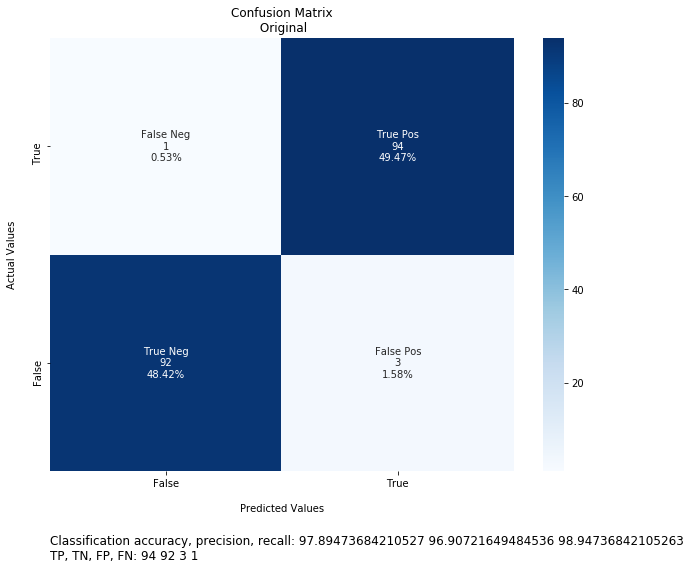

In [11]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10,8))

cf_matrix =confusion_matrix(Y_test,predictionsTest)
cf_matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(f'Confusion Matrix\n {mode}');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim([0,2])

ax.text(0, -0.2, test_set_metrics, wrap=True, horizontalalignment='left', fontsize=12, transform = ax.transAxes)

plt.tight_layout()

plt.savefig(f"/data/p301081/astronomy/results/plots_kids/cf_test_{mode}.png")

plt.show()

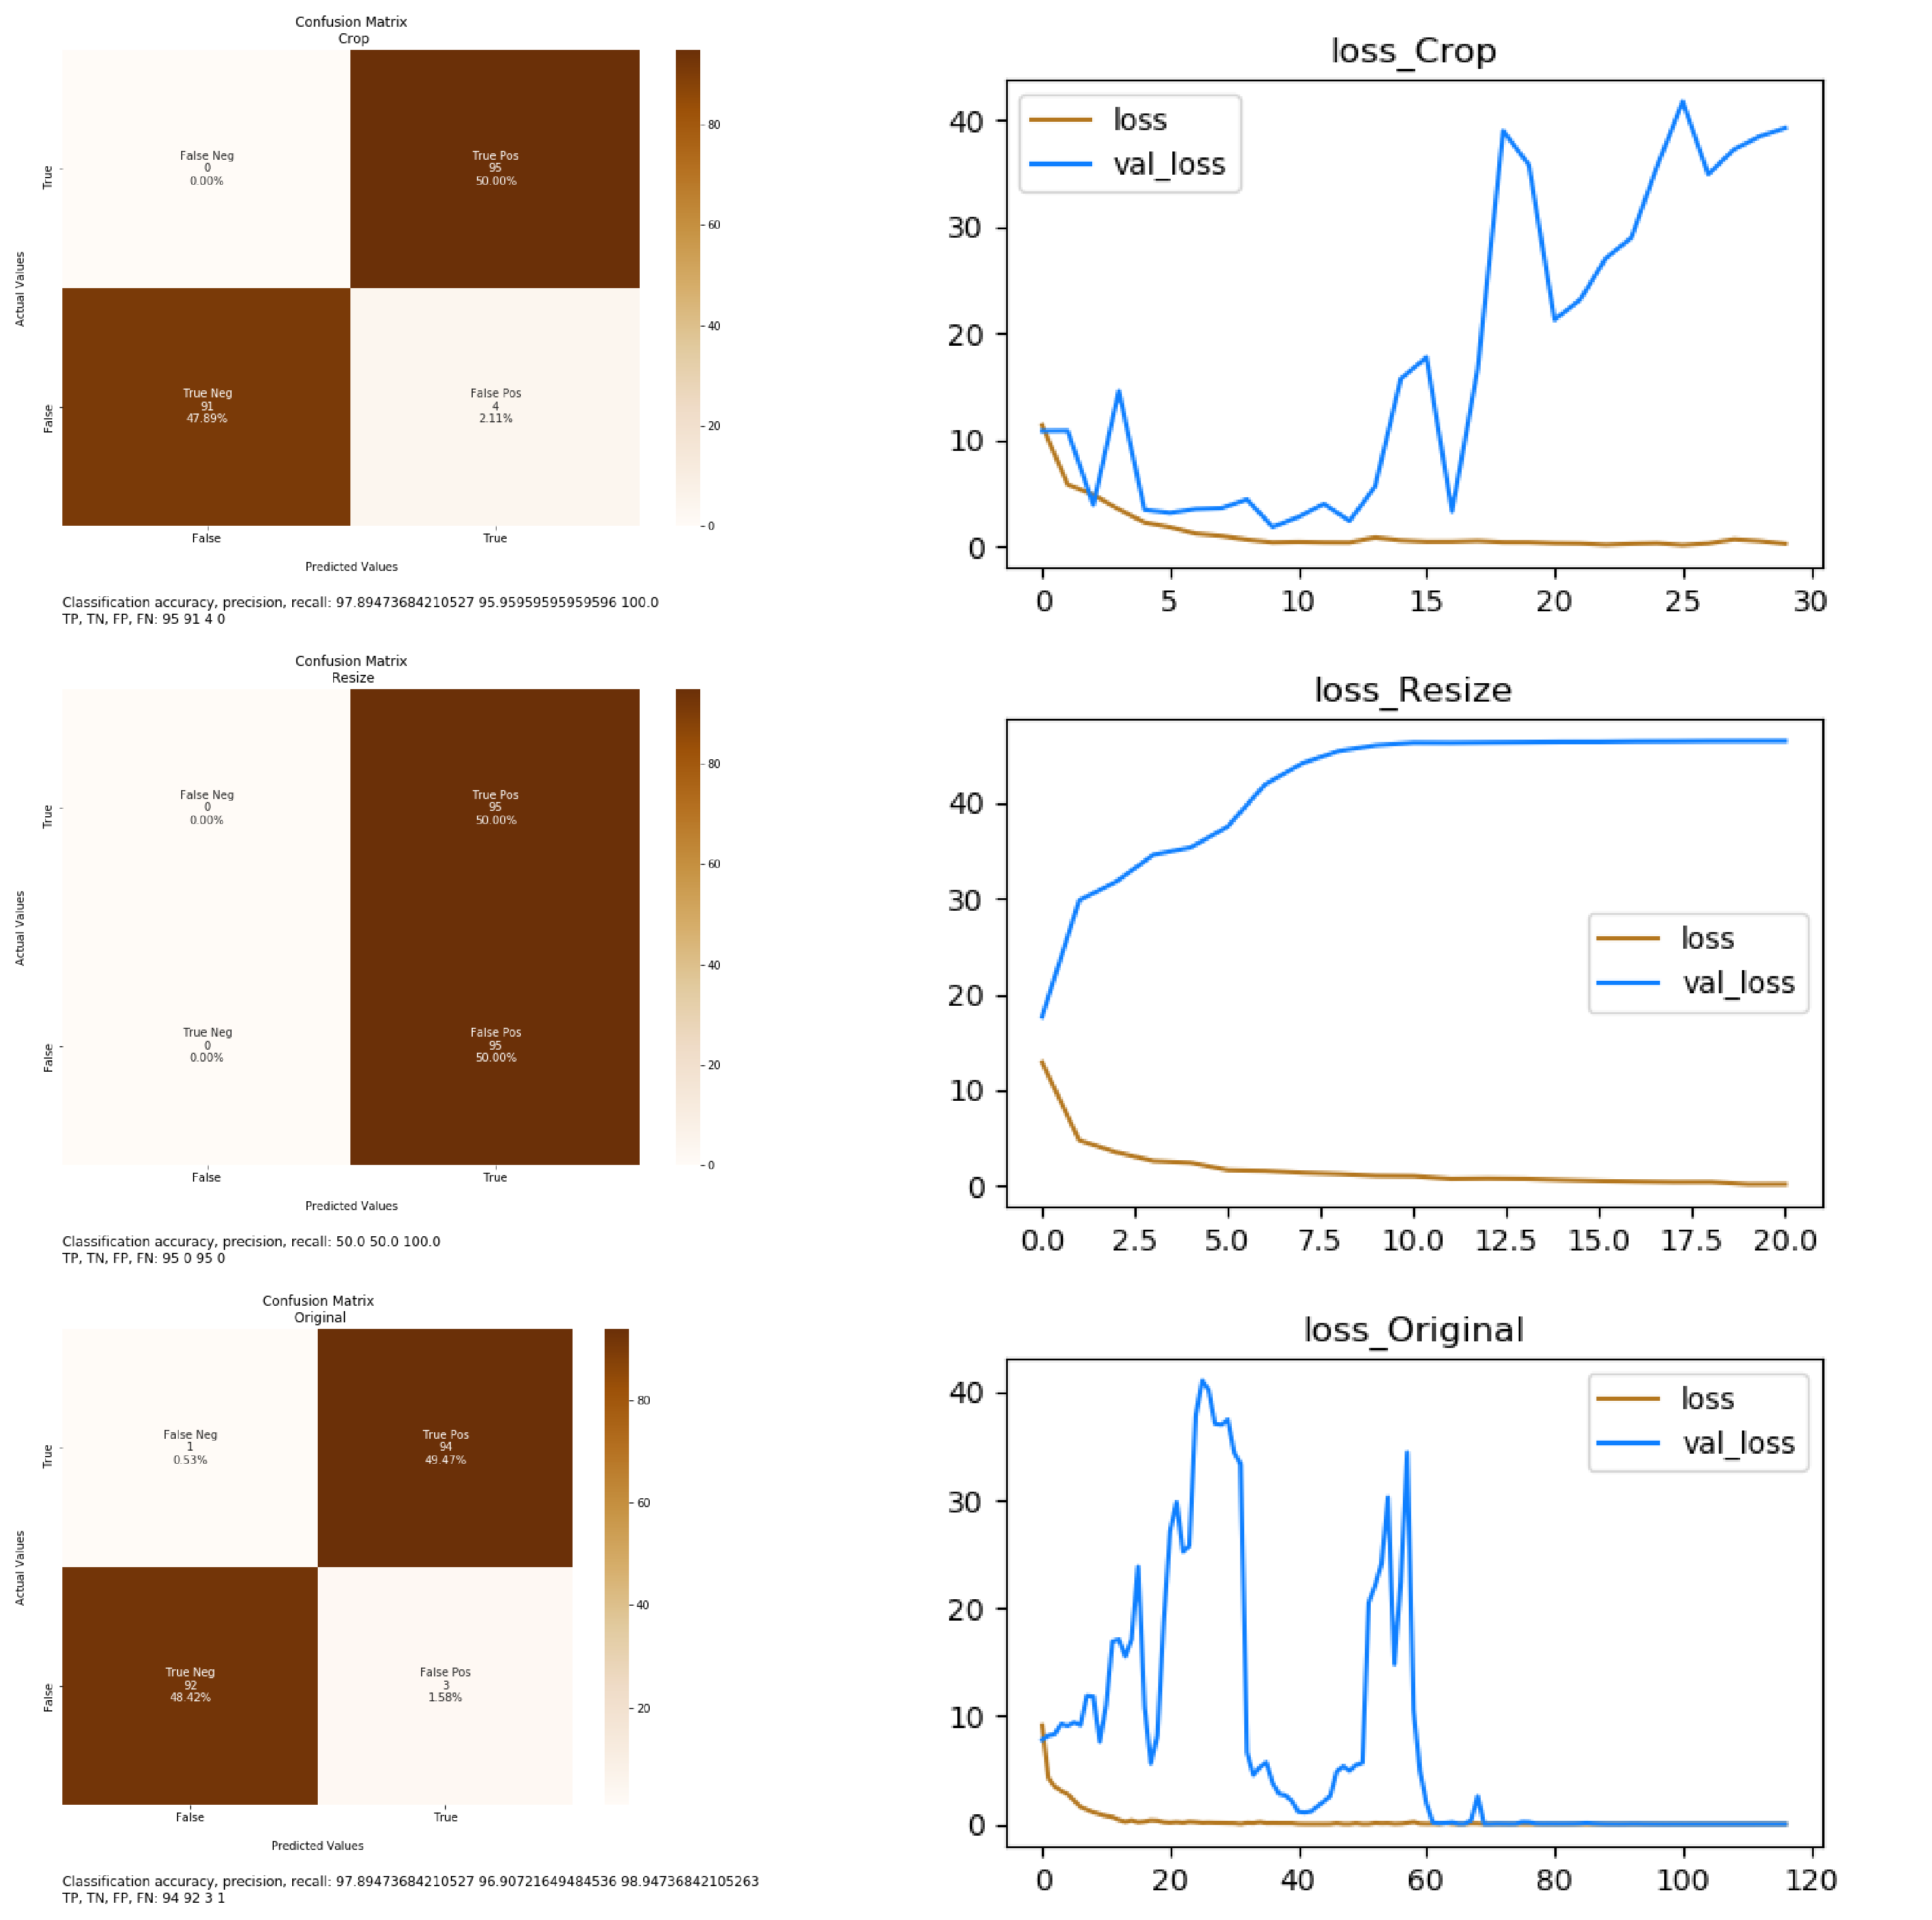

In [11]:

# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
plots_path = "/data/p301081/astronomy/results/plots_kids/"

# create figure
fig = plt.figure(figsize=(50,45))
  
# setting values to rows and column variables
rows = 3
columns = 2
  
# reading images
plt00 = cv2.imread(f'{plots_path}cf_test_Crop.png')
plt01 = cv2.imread(f'{plots_path}loss_Crop.png')
plt10 = cv2.imread(f'{plots_path}cf_test_Resize.png')
plt11 = cv2.imread(f'{plots_path}loss_Resize.png')
plt20 = cv2.imread(f'{plots_path}cf_test_Original.png')
plt21 = cv2.imread(f'{plots_path}loss_Original.png')
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(plt00)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(plt01)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(plt10)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(plt11)
plt.axis('off')
plt.title("")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(plt20)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(plt21)
plt.axis('off')
plt.title("")

plt.tight_layout()

plt.savefig(f"/data/p301081/astronomy/results/plots_kids/all_results.png")

#plt.show()